In [5]:
from pygeoinf.interval import (
Lebesgue, Sobolev, Laplacian,
IntervalDomain, BoundaryConditions,
BesselSobolevInverse, Gradient, Function,
SOLAOperator)
from pygeoinf import EuclideanSpace
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Set up the corrected configuration for investigating Laplacian accuracy
func_domain = IntervalDomain(0, 1)
bcs = BoundaryConditions('dirichlet')
dim_M = 1  # Use higher resolution for better accuracy

# Create spaces with consistent dimensions
M_underlying = Lebesgue(dim_M, func_domain, basis='fourier')
L = Laplacian(M_underlying, bcs)
M = Sobolev(M_underlying, 5.0, 1.0, L, dofs=dim_M)

D = EuclideanSpace(1)  # Data space
# Create Laplacian operator for testing
kernel = Function(M_underlying, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
kernel_sobolev = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
G = SOLAOperator(M_underlying, D, kernels=[kernel])
G_sobolev = SOLAOperator(M, D, kernels=[kernel_sobolev])


In [7]:
m_dual = M.to_dual(kernel)


<Axes: title={'center': 'Function on [0.0, 1.0]'}, xlabel='x', ylabel='f(x)'>

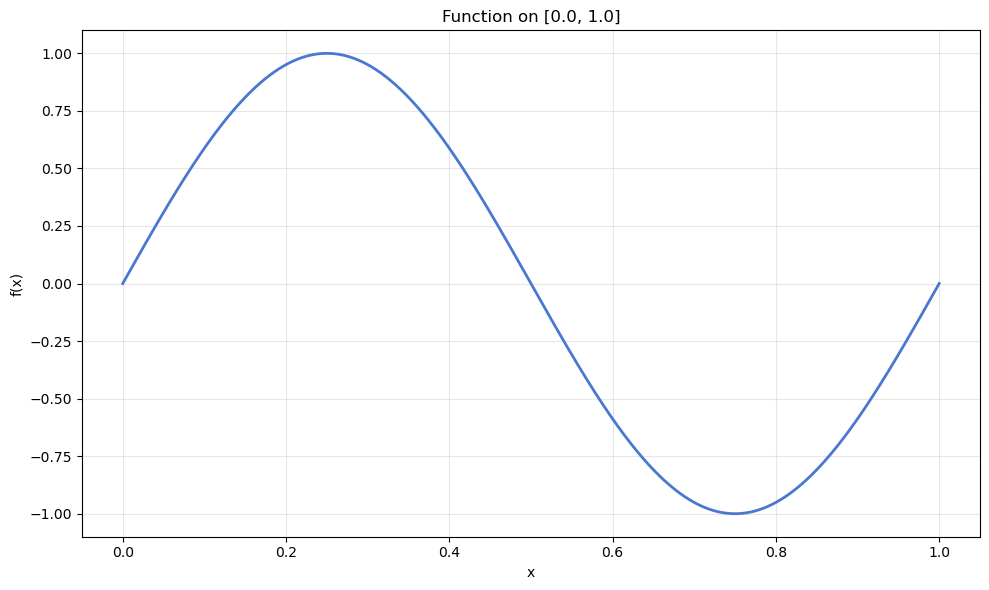

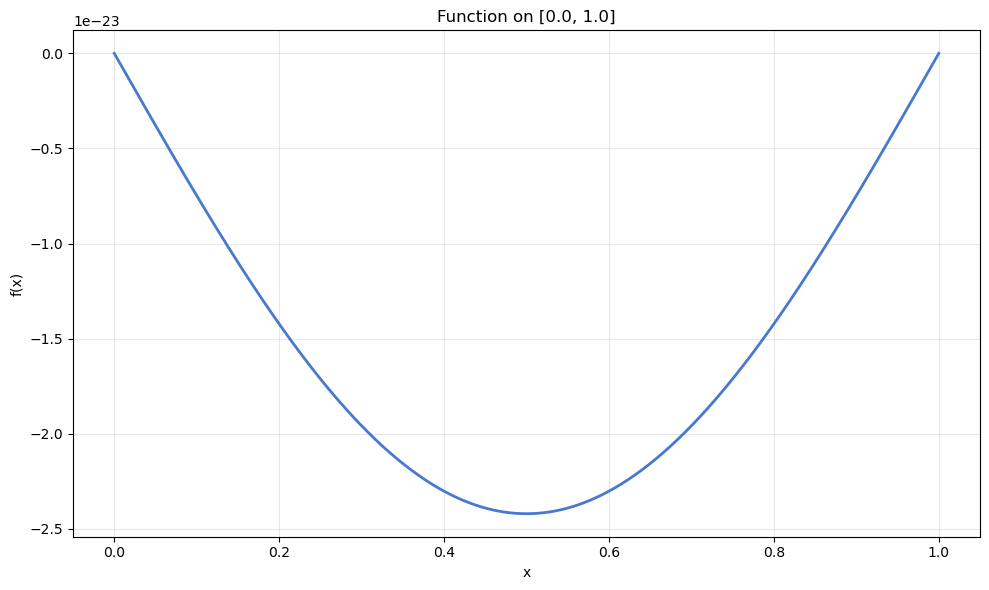

In [8]:
G.adjoint(D.basis_vector(0)).plot()
G_sobolev.adjoint(D.basis_vector(0)).plot()